In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from  sklearn.preprocessing import StandardScaler
from sklearn.model_selection  import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
import sklearn.metrics as metrics
from sklearn.metrics import precision_score ,recall_score , precision_recall_curve , f1_score , accuracy_score , fbeta_score


In [3]:
import xgboost as xgb

In [4]:
from xgboost import XGBClassifier

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [5]:
df = pd.read_csv(r'C:\Users\hp\Downloads\credit card fraud detection project\creditcard.csv')

In [6]:
df.shape

(284807, 31)

In [7]:
df1 = df.copy()

In [8]:
df1.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [9]:
## lets look at our target column in order to determine  the class imbalance in our target column 
# target is equal to class

In [10]:
df1.Class.value_counts()
## 1 in case of fraud and 0 in case of  normal

0    284315
1       492
Name: Class, dtype: int64

In [11]:
#lets look at percent wise
df1.Class.value_counts()/len(df1.Class)*100
## very less case for fraud detection  , here we can definately say if we  build the model 
## without treating class imbalance there are high chances prediction will turn out to be bias 
## while accuracy of the model will be good ,so we have to be  aware of bias error

0    99.827251
1     0.172749
Name: Class, dtype: float64

In [12]:
## now lets do some  basic eda
df1.info()
## most of the columns are numerical with no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [13]:
df1.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [14]:
df1.columns[:-1]


Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

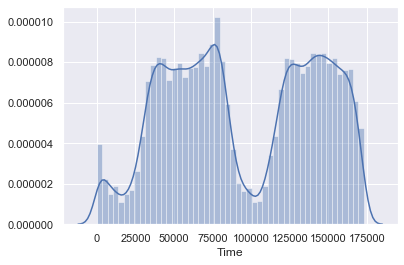

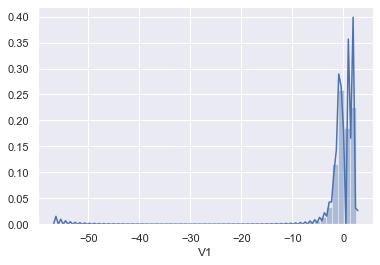

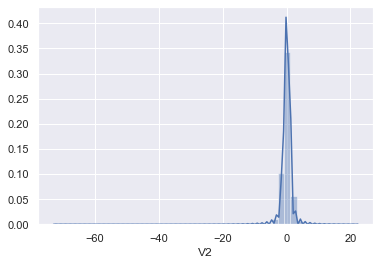

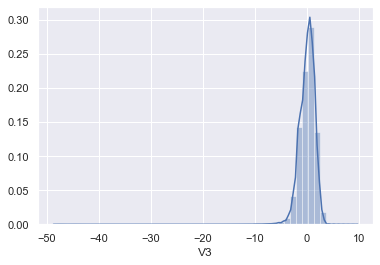

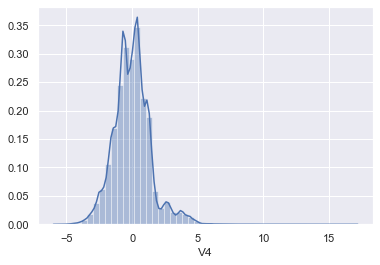

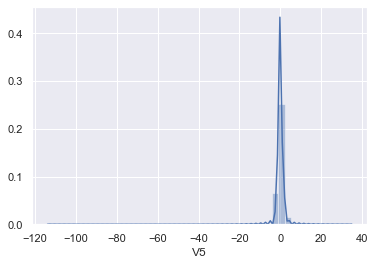

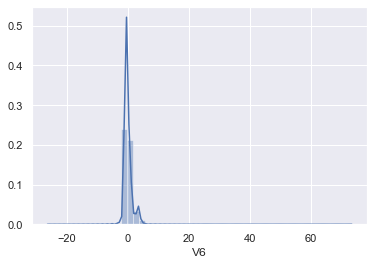

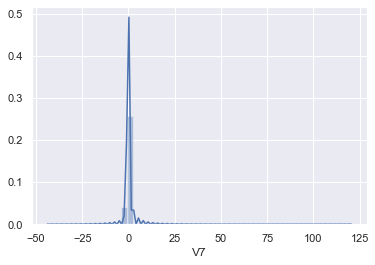

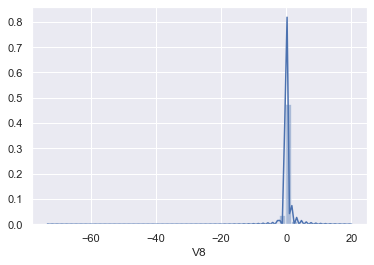

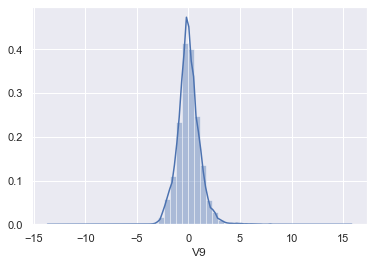

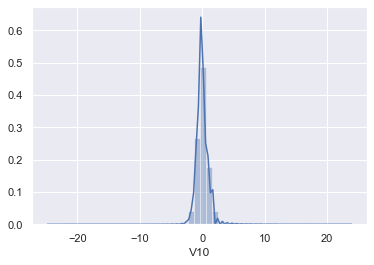

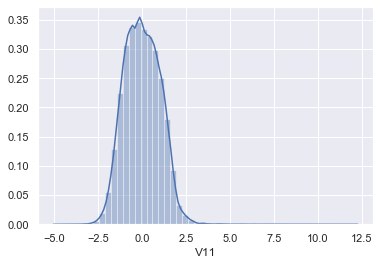

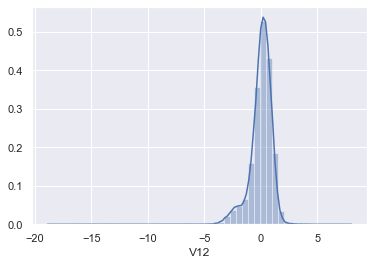

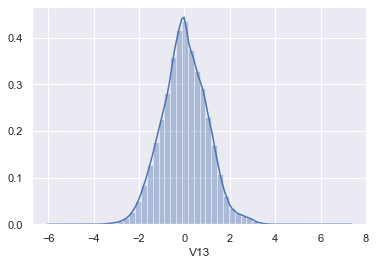

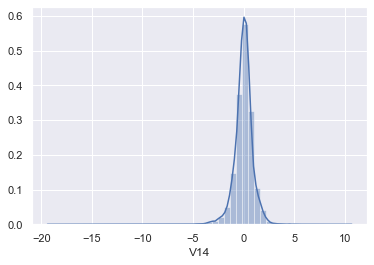

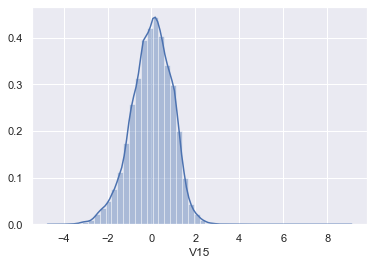

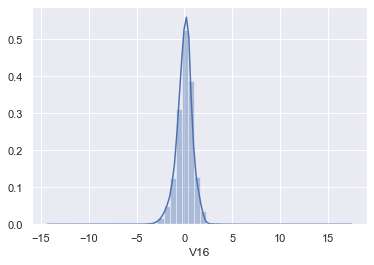

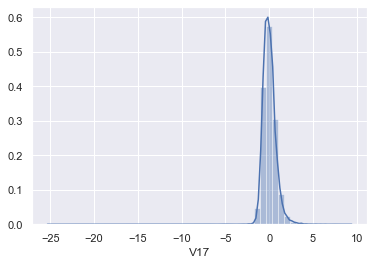

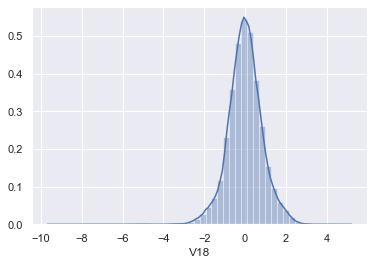

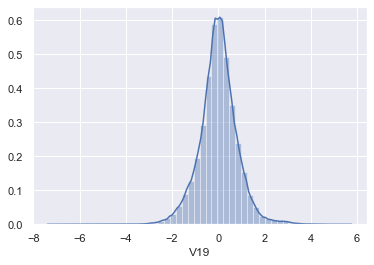

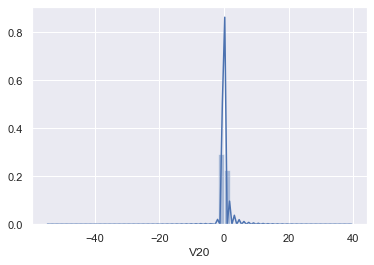

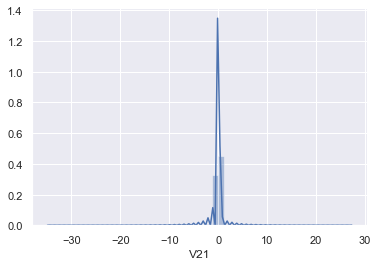

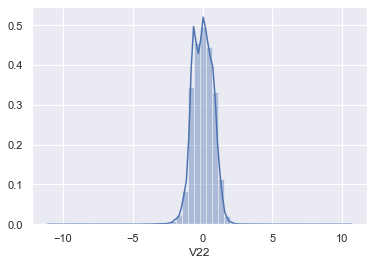

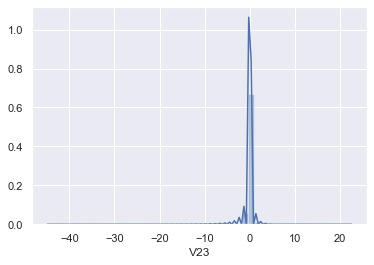

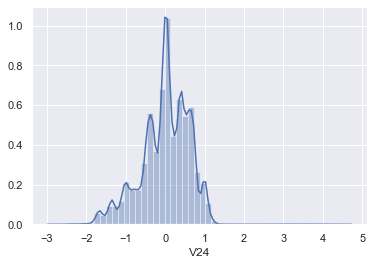

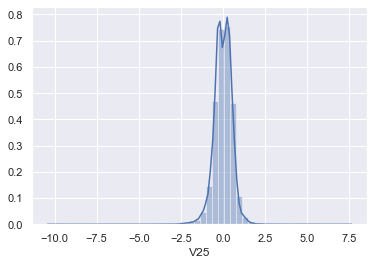

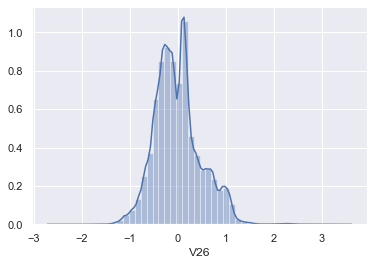

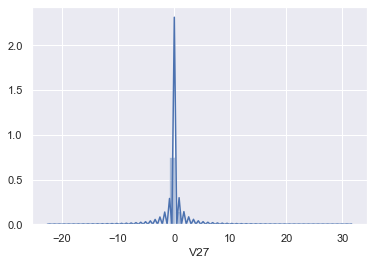

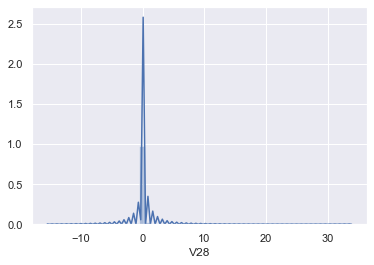

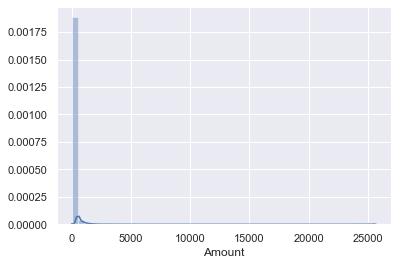

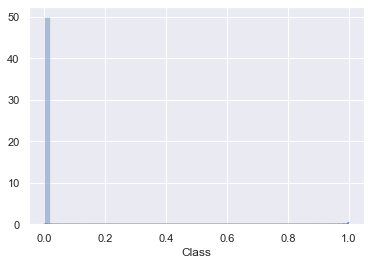

In [34]:
for i in df1.columns:
    
    sns.distplot(df1[i])
    plt.show()

In [35]:
## most of the columns are showing bell shaped plot although scaling is needed to bring the data 
## on a single scale

In [15]:
#sns.pairplot(df1 , diag_kind = 'kde')  taking  lot of time 

In [16]:
# as told in discription v1 , v2 , v3........v28 are PCA , hence we are going to select our main columns

In [17]:
df1.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [18]:
df2 = df1[['Time' , 'Amount' , 'Class']]
df2.shape

(284807, 3)

In [19]:
df2.isnull().sum() ## no missing values

Time      0
Amount    0
Class     0
dtype: int64

In [20]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 3 columns):
Time      284807 non-null float64
Amount    284807 non-null float64
Class     284807 non-null int64
dtypes: float64(2), int64(1)
memory usage: 6.5 MB


In [21]:
###  EDA , visualization  of data

In [22]:
a = df2.iloc[: ,:2]
a

,Time,Amount
0,0.0,149.62
1,0.0,2.69
2,1.0,378.66
3,1.0,123.50
4,2.0,69.99
...,...,...
284802,172786.0,0.77
284803,172787.0,24.79
284804,172788.0,67.88
284805,172788.0,10.00


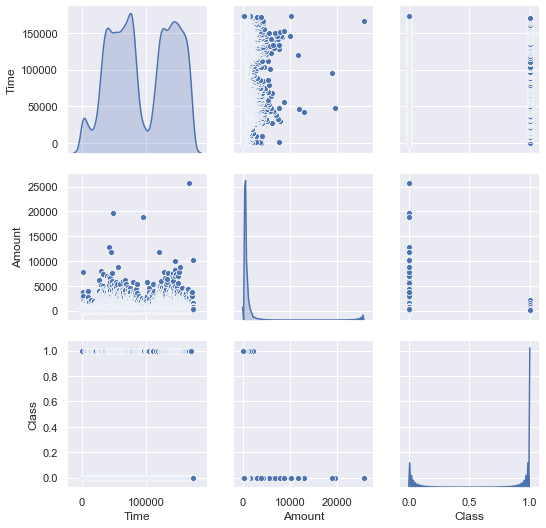

In [23]:
sns.pairplot(df2 , diag_kind = 'kde' )

In [24]:
# time is bimodal , class has discrete values of 0 and 1 ,
#amount feature  covers the large range but chart is spiked for particular values 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


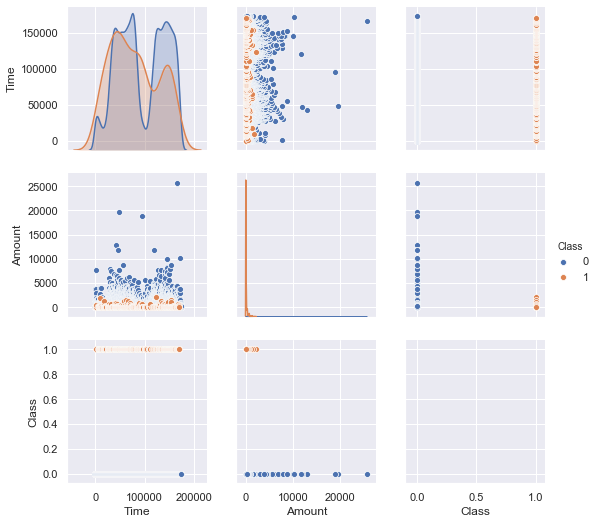

In [71]:
sns.pairplot(df2 , diag_kind = 'kde' , hue = 'Class'  )

In [25]:
# lets check the corelation among the features
df2.corr()

,Time,Amount,Class
Time,1.000000,-0.010596,-0.012323
Amount,-0.010596,1.000000,0.005632
Class,-0.012323,0.005632,1.000000


In [26]:
# corelation between features are close to zero which is good , i.e feature independence but 
# there is also low corelation of features with target variable

In [27]:
# univariate analysis

In [28]:
## distribution pot 

Text(0.5, 1.0, 'distributiom plot of class ')

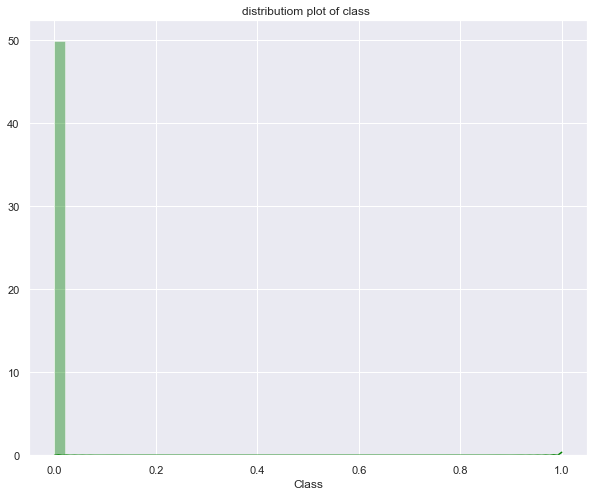

In [29]:
plt.figure(figsize = [10,8])
sns.distplot(df2['Class'] ,color = 'green'  )
plt.title('distributiom plot of class ')
## values ore concentrated on zero

In [30]:
df2.columns


Index(['Time', 'Amount', 'Class'], dtype='object')

In [31]:
## ditribution plot of amount 

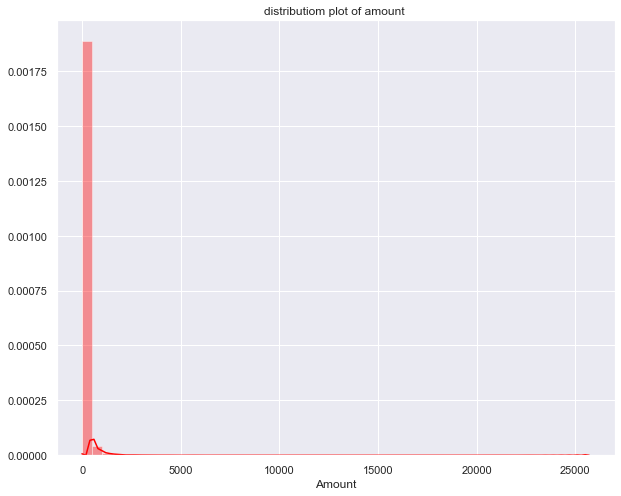

In [32]:
plt.figure(figsize = [10,8])
sns.distplot(df2['Amount'] ,color = 'RED'  )
plt.title('distributiom plot of amount ')
plt.show()
## 

In [33]:
## at lower amount there is a high distribution this could be because of more marginal customers 
# or there are mre number of peopole who have opted for credit card which has a lesser limit

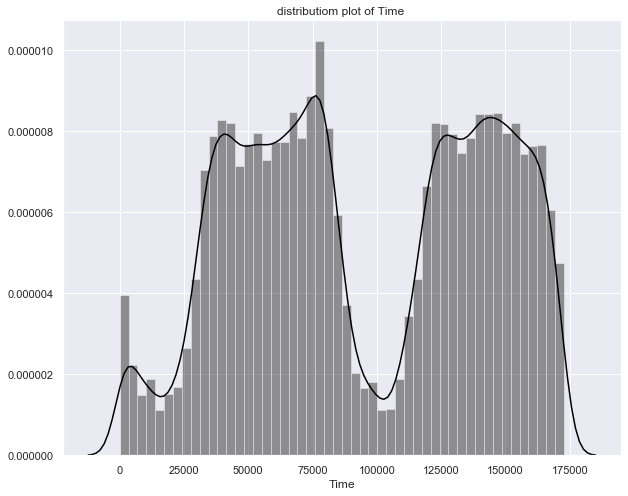

In [34]:
plt.figure(figsize = [10,8])
sns.distplot(df2['Time'] ,color = 'Black'  )
plt.title('distributiom plot of Time ')
plt.show()
## values ore concentrated on zero

In [35]:
## its a bimodal plot it needs to be analysed more ,
## i.e impact on this feature becouse of other variables

Text(0.5, 1, 'heatmap of corelation ')

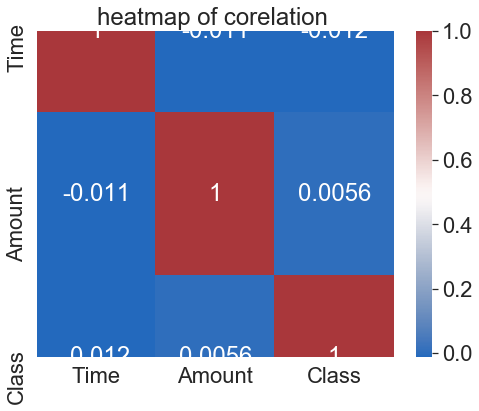

In [36]:
## corelation plot through heat map
plt.figure(figsize = [8,6])
sns.set(font_scale=2)
sns.heatmap(df2.corr() , annot = True , cmap = 'vlag'  )
plt.title('heatmap of corelation ')
## values ore concentrated on zero

In [37]:
# different cmap styles
# _r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, 
# gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, 
# gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yar 

In [38]:
# more styles
#  spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b,
# tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, 
#     twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r

In [39]:
 df.corr()[df.corr()>0.5]['Class']  ### no high corelation for target variable

Time      NaN
V1        NaN
V2        NaN
V3        NaN
V4        NaN
V5        NaN
V6        NaN
V7        NaN
V8        NaN
V9        NaN
V10       NaN
V11       NaN
V12       NaN
V13       NaN
V14       NaN
V15       NaN
V16       NaN
V17       NaN
V18       NaN
V19       NaN
V20       NaN
V21       NaN
V22       NaN
V23       NaN
V24       NaN
V25       NaN
V26       NaN
V27       NaN
V28       NaN
Amount    NaN
Class     1.0
Name: Class, dtype: float64

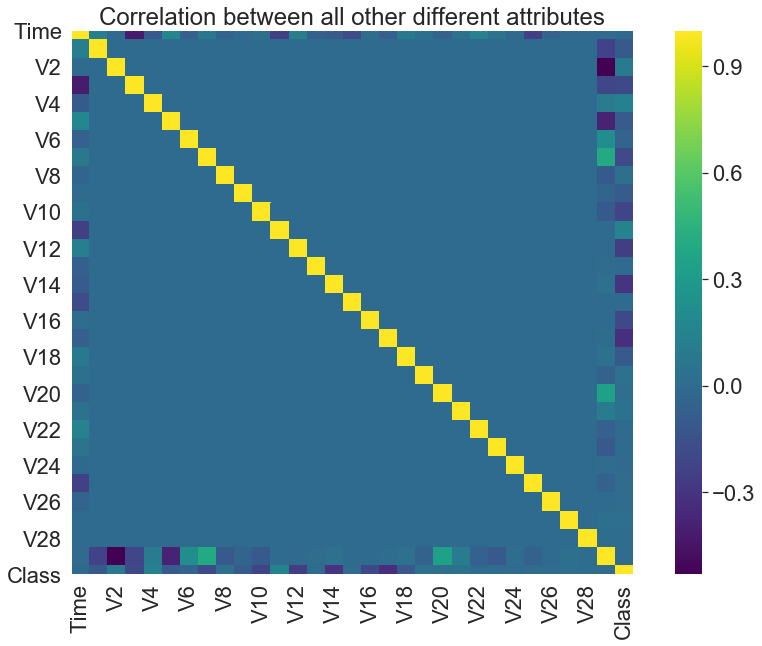

In [40]:
plt.figure(figsize=(15,10))

sns.heatmap(df.corr(), vmax=1, square=True,cmap='viridis')
plt.title('Correlation between all other different attributes')
plt.show()

In [41]:
## pie plot of froud vs no nnon froud

In [42]:
fraud = len(df2[df2['Class']==1])
nfraud = len(df2[df2['Class']==0]) # class seperation 

In [43]:
labels = 'Fraud' , 'Not Fraud'
data = [fraud , nfraud]

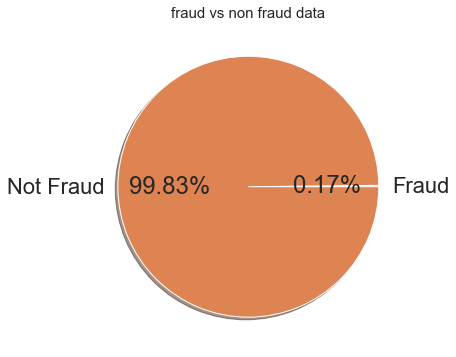

In [44]:
# plot
plt.figure(figsize = [8,6])
plt.pie(data ,labels =  labels , autopct = '%1.2f%%' ,startangle=0, shadow = True)
plt.title('fraud vs non fraud data' , fontsize =15)
plt.show()

In [45]:
## now  when we are building our model we are going to use all deature inside the data
## so here we are going to se df1 as our dataframe

In [46]:
X = df1.drop('Class' , axis =1)
y = df1['Class']

In [47]:
X.shape , y.shape

((284807, 30), (284807,))

In [48]:
## train test split
xtrain ,xtest ,ytrain, ytest = train_test_split(X ,y  ,test_size = .25  , random_state  = 27)

In [49]:
xtrain.shape ,xtest.shape ,ytrain.shape, ytest.shape

((213605, 30), (71202, 30), (213605,), (71202,))

In [50]:
# now here we can do power transform  on train test data
## or we can do the testing as it is , as we will not get any test data to transform in real world

In [51]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()

In [52]:
xtraint =pd.DataFrame(pt.fit_transform(xtrain) , columns = xtrain.columns)
xtraint
xt = xtraint  # short form 

In [53]:
xtestt = pt.transform(xtest)
xtt  = xtestt
xtt

array([[-1.06765646,  0.64085758, -0.18573841, ..., -0.16570663,
         0.03563459, -0.77355894],
       [ 1.02191572, -0.19541123,  0.41358793, ...,  0.03649123,
         0.1252243 ,  0.22506034],
       [ 1.2571391 , -0.75510719,  0.91000843, ..., -0.04977806,
         0.53727309,  1.35664175],
       ...,
       [ 0.69200006,  1.327707  ,  0.05070412, ..., -0.04523008,
        -0.14302213, -1.38323556],
       [ 1.40281726, -0.66824369,  1.08921933, ...,  0.9114118 ,
         0.77337891, -0.45725657],
       [ 0.6503356 , -0.66097398,  0.84186098, ...,  1.30125858,
         0.71996685, -0.55435467]])

In [54]:
xtt  = pd.DataFrame(xtt , columns = xtest.columns)
xtt.shape

(71202, 30)

In [55]:
## applying logestic regression as our base model and we  will look for biaseness in 
# the model  through our classification report

In [56]:
from sklearn .linear_model import LogisticRegression

In [57]:
lr =  LogisticRegression()

In [58]:
 ## logestic regression on our simple data  , xtrian  , xtest
    

In [59]:
lr.fit(xtrain ,ytrain )
lr.score(xtrain , ytrain) # score for our train data

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.999059010790946

In [60]:
ypred = lr.predict(xtest)


In [61]:
type(ytest)

pandas.core.series.Series

In [62]:
# lr.score(ytest ,ypred ) ## better to predict classification report

In [63]:
print(classification_report(ytest ,ypred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71070
           1       0.77      0.75      0.76       132

    accuracy                           1.00     71202
   macro avg       0.89      0.87      0.88     71202
weighted avg       1.00      1.00      1.00     71202



In [64]:
# for class 1 precision is  comparetively low  , as thee are more number of instances for class 0

In [65]:
# now for transformed data 

In [66]:
lr.fit(xt , ytrain)

LogisticRegression()

In [67]:
lr.score(xt , ytrain) ## train core   ## slightly improved

0.9992041384799045

In [68]:
ypredt= lr.predict(xtt)

In [69]:
ypredt = ypredt.reshape(-1,1)

In [70]:
cr = classification_report 

In [71]:
print(cr(ytest, ypredt))
## if we compare these two report we will  see that after transformation precision has 
## been improved but at the cost of recall , so for the given data we need to decide 
## on what matrix we shoul focus 
## precison = ability of clasifier to not to predict positive something which is negative
# t.p/(t.p+f.p)
## recall =  t.p(t.p+f.n)
# its the abilty to not to predict negetive something which is actually posetive
## here if we detect the fraud and we are wrongly classifying as negative i.e 0  will be a major 
## set back for our bussiness problem
## here we need more recall score then precison score

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71070
           1       0.92      0.65      0.76       132

    accuracy                           1.00     71202
   macro avg       0.96      0.83      0.88     71202
weighted avg       1.00      1.00      1.00     71202



In [72]:
print(classification_report(ytest ,ypred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71070
           1       0.77      0.75      0.76       132

    accuracy                           1.00     71202
   macro avg       0.89      0.87      0.88     71202
weighted avg       1.00      1.00      1.00     71202



In [73]:
## lets increase the number of indtances for zero without actually  adding new information for 
# class zero 

In [74]:
## concatinating the data for oversampling
inp = pd.concat([xtrain , ytrain] , axis =1)
inp.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
264873,161634.0,-0.395578,1.489129,-0.833442,-0.224271,0.369444,-1.453886,0.796593,-0.060403,0.338270,...,0.231624,0.955194,-0.172092,-0.041050,-0.313444,-0.174301,0.064657,-0.036960,2.74,0
163821,116237.0,1.950487,0.002312,-1.761814,1.232470,0.523175,-0.650657,0.504231,-0.200857,0.116805,...,0.086306,0.326297,-0.068839,-0.416589,0.426044,-0.486299,-0.031266,-0.072543,38.44,0
72083,54557.0,1.105167,-0.166253,0.569520,0.681043,-0.259189,0.642792,-0.437034,0.356746,0.441417,...,0.009073,0.293023,-0.028688,-0.242206,0.389813,0.482852,0.010705,-0.008399,1.00,0
196949,131771.0,1.805238,0.961264,-1.717212,4.094625,0.938666,-0.227785,0.152911,0.066753,-1.073784,...,-0.137875,-0.450959,0.098530,-0.662272,-0.150154,-0.098852,-0.000030,0.017622,37.89,0
126213,77959.0,0.835421,-1.191847,0.578455,0.586101,-1.236663,0.194617,-0.532404,0.061561,-0.734344,...,-0.072349,-0.109154,-0.308356,0.011968,0.461350,-0.244810,0.031845,0.060910,237.00,0


In [75]:
not_fraud = inp[inp['Class'] ==0]
fraud = inp[inp['Class']==1]
(len(not_fraud)+1)/2 

106623.0

In [76]:
## upsampling

from sklearn.utils import resample
# seperate the data
not_fraud = inp[inp['Class'] ==0]
fraud = inp[inp['Class']==1]

# increasing the number of cases fro minority
f_upsample =resample(fraud , replace = True # sample with replacement
                    ,n_samples = 106623       ###int(len(not_fraud)+1)/2   = 106623 # matcing half of the length
                    ,random_state =27)
upsample = pd.concat([not_fraud , f_upsample])

upsample['Class'].value_counts()


## it will be wrong to make  minority  class as equal to majority   class as in actual case ,
# there will be shortage of cases of fraud

0    213245
1    106623
Name: Class, dtype: int64

In [77]:
xu = upsample.drop('Class' , axis =1)
yu = upsample['Class']

In [78]:
#  applying logestic  regression 
lr1 = LogisticRegression()

In [79]:
lr1.fit(xu ,yu)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [80]:
lr1.score(xu ,yu) # train score has been decrease as compared to previous model 

0.9572010954518739

In [81]:
ypredu = lr1.predict(xtest)

In [82]:
# lets look at classification report
print(cr(ytest, ypredu))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71070
           1       0.08      0.89      0.15       132

    accuracy                           0.98     71202
   macro avg       0.54      0.93      0.57     71202
weighted avg       1.00      0.98      0.99     71202



In [83]:
## we can see the improvement in recall score , but precision score is very poor ,also f1-score

In [84]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(confusion_matrix(ytest , ypredu))

,0,1
0,69707,1363
1,15,117


In [85]:
## number of false posetive has been increased 

In [86]:
# n values initialization
len(fraud)*2

720

In [87]:
## downsampling

from sklearn.utils import resample
# seperate the data
not_fraud = inp[inp['Class'] ==0]
fraud = inp[inp['Class']==1]

# increasing the number of cases fro minority
nf_dnsample =resample(not_fraud , replace = True # sample with replacement
                    ,n_samples = 720      ### len(fraud)*2  = 720 # matcing half of the length
                    ,random_state =27)
dnsample = pd.concat([fraud , nf_dnsample])

dnsample['Class'].value_counts()


0    720
1    360
Name: Class, dtype: int64

In [88]:
## again implementing logestic regression

xd = dnsample.drop('Class' , axis =1)
yd = dnsample['Class']

In [89]:
lr2 = LogisticRegression()

In [90]:
lr2.fit(xd ,yd)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [91]:
lr2.score(xd,yd)

0.9611111111111111

In [92]:
ypredd = lr2.predict(xtest)

In [93]:
print(cr(ytest, ypredd))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71070
           1       0.07      0.89      0.13       132

    accuracy                           0.98     71202
   macro avg       0.54      0.94      0.56     71202
weighted avg       1.00      0.98      0.99     71202



In [94]:
## precision score  , f1-score  again reduced , without any improvement recall case from upsmapling

In [95]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(confusion_matrix(ytest , ypredd))

,0,1
0,69531,1539
1,14,118


In [96]:
## now generating  synthatic samples  by SMOT (synthatic minority oversmapling technique)

In [97]:
from imblearn.over_sampling import SMOTE

y1 = df1['Class']
x1 = df1.drop('Class' ,axis =1)

In [98]:
xtrain1 , xtest1 ,ytrain1 ,ytest1 = train_test_split(x1,y1 , test_size = 0.25 , random_state =27)

In [99]:
sm = SMOTE(random_state = 27)
xtrain1 ,ytrain1 = sm.fit_sample(xtrain1 ,ytrain1)

In [100]:
xtrain1.shape ,ytrain1.shape  ## oversampling

((426490, 30), (426490,))

In [101]:
# LIBLINEAR is a linear classifier for data with millions of instances and features

In [102]:
smote = LogisticRegression(solver = 'liblinear').fit(xtrain1 ,ytrain1)
smote.score(xtrain1,ytrain1)

0.9638279912776384

In [103]:
s_pred = smote.predict(xtest1)

In [104]:
# classification report
print(cr(ytest1 , s_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     71070
           1       0.10      0.86      0.18       132

    accuracy                           0.99     71202
   macro avg       0.55      0.92      0.59     71202
weighted avg       1.00      0.99      0.99     71202



In [105]:
accuracy_score(ytest1, s_pred)  ## it deceptive as we can see that precission score is very low

0.9858571388444145

In [268]:
## little bit improvement in the precision of fraud class values , but still it is poor 

In [272]:
 confusion_matrix(ytest1, s_pred)

array([[70081,   989],
       [   18,   114]], dtype=int64)

In [107]:
from sklearn.model_selection import cross_val_score , KFold ,GridSearchCV

In [108]:
## random forest classifier
rf = RandomForestClassifier()

In [109]:
## random forest on largedata will take time as  if we dont find the best parameter for rfc it will be waste tom implement

In [110]:
rf_be = []  ## testing on downsample data
rf_ve =[]
for n  in  np.arange(1,50):
    rf =  RandomForestClassifier(n_estimators = n , criterion = 'entropy' , random_state = 27 , n_jobs =-1)
    kf = KFold(shuffle =True , random_state =27  , n_splits =5)
    score = cross_val_score(rf  , xd , yd , cv = kf , scoring = 'roc_auc' )
    rf_be.append(np.mean(score))
    rf_ve.append(np.std(1-score ,ddof =1))  

In [112]:
np.min(rf_ve) , np.argmin(rf_ve) , rf_be[48]   #  we are unaware of  recall score and precison score

(0.009562454249185809, 48, 0.9813747668395463)

In [281]:
# lets apply random forest on randomly selected n_estimators

In [283]:
rf = RandomForestClassifier(n_estimators = 10  ,random_state =27)  # for full data 
rf.fit(xtrain , ytrain )

RandomForestClassifier(n_estimators=10, random_state=27)

In [284]:
rf.score(xtrain , ytrain )

0.99990636923293

In [285]:
rfpred = rf.predict(xtest)

In [286]:
# lets check  classification report 
print(cr(ytest, rfpred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71070
           1       0.97      0.81      0.88       132

    accuracy                           1.00     71202
   macro avg       0.99      0.91      0.94     71202
weighted avg       1.00      1.00      1.00     71202



In [287]:
## this one seems a better result for predicting a minority class as both precision , recall , and f1 score are good
# compare to logistic regression ,if we can do hyperparameter tunning , the score can imrove , for uthat we need to use 
#undersampled data

In [289]:
pd.DataFrame(confusion_matrix(ytest, rfpred))

,0,1
0,71067,3
1,25,107


In [290]:
## score is  improved drastically as we can see it

In [291]:
#naive bayes
nb = GaussianNB( random_state =27)  ## we cant do parameter tunning already tunned

In [292]:
nb.fit(xtrain ,ytrain )
nb.score(xtrain , ytrain )

0.9929776924697455

In [294]:
nbpred  = nb.predict(xtest)

In [296]:
# classification report 
print(cr(ytest , nbpred))  ## poor score 

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     71070
           1       0.18      0.67      0.28       132

    accuracy                           0.99     71202
   macro avg       0.59      0.83      0.64     71202
weighted avg       1.00      0.99      1.00     71202



In [ ]:
## grid searchcv for support vector classifier

In [ ]:
# C = [1]
# gammas = [.001 , 0.1]
# param_grid = dict(C= C ,gamma = gammas )

# svm1 = svm.SVC(kernel  =  'rbf' , probability  = True)
# svm_grid = GridSearchCV(svm1 , param_grid , cv =5  ,scoring = 'roc_auc' ,n_jobs = -1 , verbose = 10)
# svm_grid.fit(xtrain , ytrain) ## taking too much time 

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [119]:
## randomized search cv  for hyper parameter tunning
rf = RandomForestClassifier(random_state =27)

In [117]:

from sklearn.model_selection import RandomizedSearchCV  # for random forest


In [120]:
kf = KFold(shuffle = True , n_splits = 5 , random_state  = 27)
param = {'n_estimators' :np.arange(1,30) , 'criterion' : ['gin' , 'entropy']}
RS = RandomizedSearchCV(rf , param , cv = kf , scoring = 'roc_auc')
RS.fit(xtrain  , ytrain)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 921, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\ProgramData\Anacon

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 921, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\ProgramData\Anacon

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 921, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\ProgramData\Anacon

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 921, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\ProgramData\Anacon

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 921, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\ProgramData\Anacon

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=27, shuffle=True),
                   estimator=RandomForestClassifier(random_state=27),
                   param_distributions={'criterion': ['gin', 'entropy'],
                                        'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
                   scoring='roc_auc')

In [121]:
RS.best_params_

{'n_estimators': 29, 'criterion': 'entropy'}

In [124]:
## lets check on downsized data 
kf = KFold(shuffle = True , n_splits = 5 , random_state  = 27)
param = {'n_estimators' :np.arange(1,50) , 'criterion' : ['gin' , 'entropy']}
RS = RandomizedSearchCV(rf , param , cv = kf , scoring = 'roc_auc')
RS.fit(xd  , yd)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 921, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\ProgramData\Anacon

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 921, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\ProgramData\Anacon

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 921, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\ProgramData\Anacon

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 921, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\ProgramData\Anacon

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 921, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\ProgramData\Anacon

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=27, shuffle=True),
                   estimator=RandomForestClassifier(random_state=27),
                   param_distributions={'criterion': ['gin', 'entropy'],
                                        'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
                   scoring='roc_auc')

In [125]:
RS.best_params_

{'n_estimators': 20, 'criterion': 'entropy'}

In [154]:
rfc1 = RandomForestClassifier(n_estimators = 20 , criterion = 'entropy' ,random_state= 27)

In [155]:
rfc1.fit(xd, yd)

RandomForestClassifier(criterion='entropy', n_estimators=20, random_state=27)

In [156]:
rfc1.score(xd, yd)

0.9962962962962963

In [130]:
ypredc = rfc1.predict(xtest)

In [151]:
accuracy_score(ytest , ypredc)

0.9905480183140923

In [132]:
## lets check classfication report
print(cr(ytest, ypredc)) #poor results no point of doing grid search 

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     71070
           1       0.15      0.84      0.25       132

    accuracy                           0.99     71202
   macro avg       0.57      0.92      0.62     71202
weighted avg       1.00      0.99      0.99     71202



In [133]:
# now lets use these  parameter
rfc2 = RandomForestClassifier(n_estimators = 29 , criterion = 'entropy' ,random_state= 27)
## number of estimators will increase if increase the  range 

In [134]:
rfc2.fit(xtrain ,ytrain)

RandomForestClassifier(criterion='entropy', n_estimators=29, random_state=27)

In [136]:
rfc2.score(xtrain ,ytrain )

0.9999765923082324

In [137]:
ypredc1 = rfc2.predict(xtest)

In [150]:
accuracy_score(ytest , ypredc1)   # test score is also doing good

0.9996067526193084

In [138]:
## lets check its classifcation report
print(cr(ytest , ypredc1))   ### this one is  is also giving good precison recall score  
# we can see every parameter is above .80  and train accuracy is 100%

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71070
           1       0.97      0.81      0.88       132

    accuracy                           1.00     71202
   macro avg       0.99      0.91      0.94     71202
weighted avg       1.00      1.00      1.00     71202



In [144]:
confusion_matrix(ytest, ypredc1)

array([[71067,     3],
       [   25,   107]], dtype=int64)

In [ ]:
## XGBOOST CLASSIFIER

In [139]:
xgc = XGBClassifier(random_state = 27)

In [140]:
xgc.fit(xtrain ,ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=27,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [141]:
xgc.score(xtrain ,ytrain )

1.0

In [142]:
ypredx = xgc.predict(xtest)

In [149]:
accuracy_score(ytest, ypredx)  ### test score looks good there is very  variation of score between train test

0.999592708069998

In [143]:
print(cr(ytest, ypredx)) 
# recall score slightly decreesed  when we compare to hypertunned random forest
## it is one of the best resul we got

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71070
           1       0.97      0.80      0.88       132

    accuracy                           1.00     71202
   macro avg       0.99      0.90      0.94     71202
weighted avg       1.00      1.00      1.00     71202



In [145]:
confusion_matrix(ytest , ypredx )

array([[71067,     3],
       [   26,   106]], dtype=int64)

In [ ]:
## now we can scle the data and can apply apply these models again  

In [ ]:
## we did power tranformation let us first check the data

In [146]:
xtt.describe() 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,71202.000000,71202.000000,71202.000000,71202.000000,71202.000000,71202.000000,71202.000000,71202.000000,71202.000000,71202.000000,...,71202.000000,71202.000000,71202.000000,71202.000000,71202.000000,71202.000000,71202.000000,71202.000000,71202.000000,71202.000000
mean,-0.001442,-0.003834,0.002165,0.001817,-0.008805,0.003225,0.006159,-0.000906,-0.000757,-0.001298,...,0.004605,-0.004770,-0.005980,-0.003951,-0.003130,0.000835,0.003485,-0.003873,0.002422,-0.000808
std,1.001387,0.998211,1.002081,0.992801,1.003159,1.000159,1.022502,0.998964,0.994123,0.997736,...,0.989769,1.023841,1.002107,0.985361,1.006662,0.995496,0.998668,0.980915,1.004860,0.997691
min,-2.433684,-6.717335,-21.156164,-10.116024,-5.016459,-22.697605,-38.662229,-31.348880,-28.266743,-13.285470,...,-33.779354,-66.177515,-13.279139,-50.685411,-3.464584,-12.785102,-7.767076,-21.476616,-32.039857,-2.011034
25%,-0.815441,-0.724242,-0.451035,-0.706665,-0.578157,-0.508411,-0.553304,-0.445013,-0.273258,-0.560242,...,-0.276743,-0.304105,-0.762905,-0.271020,-0.665366,-0.633131,-0.644163,-0.190095,-0.152770,-0.744083
50%,-0.145855,-0.255326,-0.038800,-0.024702,0.053962,-0.052449,-0.104265,0.039055,-0.054573,0.006077,...,-0.084647,-0.022615,-0.019668,-0.027183,-0.033254,-0.003057,-0.010702,-0.010819,0.048638,0.026019
75%,0.930685,0.732380,0.479534,0.670016,0.572196,0.437447,0.423935,0.465673,0.254863,0.579412,...,0.168431,0.273732,0.714053,0.229653,0.701839,0.658541,0.577477,0.213896,0.255556,0.743710
max,1.535979,1.812426,19.890257,3.982664,8.505082,27.857944,9.063067,28.446305,35.183761,7.470912,...,55.327431,28.792014,16.480623,28.255142,10.511149,13.348723,4.507783,28.282291,38.610556,3.557383


In [147]:
xt.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,...,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05
mean,-1.647925e-16,-5.083206e-19,1.507680e-17,-3.081836e-17,-3.807363e-17,-1.029687e-17,1.450741e-17,-4.399260e-17,3.937665e-18,1.109690e-17,...,2.366211e-17,-1.128928e-17,-5.458777e-17,-1.224114e-17,-2.372007e-17,5.523750e-17,2.897947e-17,-1.574805e-17,2.473255e-18,-2.096942e-16
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-2.433684e+00,-8.453188e+00,-2.362893e+01,-1.299593e+01,-4.933697e+00,-6.988689e+01,-4.432495e+01,-3.693708e+01,-2.153662e+01,-1.642888e+01,...,-6.459469e+01,-4.166961e+01,-1.163478e+01,-6.130128e+01,-3.531685e+00,-1.479289e+01,-8.042316e+00,-4.627274e+01,-6.215166e+01,-2.011034e+00
25%,-8.089239e-01,-7.237325e-01,-4.543047e-01,-7.121616e-01,-5.704985e-01,-5.121877e-01,-5.563212e-01,-4.438426e-01,-2.743941e-01,-5.605218e-01,...,-2.781151e-01,-3.029749e-01,-7.564156e-01,-2.692654e-01,-6.606300e-01,-6.323072e-01,-6.500178e-01,-1.867493e-01,-1.513687e-01,-7.557036e-01
50%,-1.419852e-01,-2.490081e-01,-4.264307e-02,-2.458516e-02,6.248454e-02,-5.590763e-02,-1.095490e-01,3.683223e-02,-5.492803e-02,8.173886e-03,...,-8.542864e-02,-2.169264e-02,-1.105005e-02,-2.791945e-02,-3.092662e-02,-5.838571e-03,-1.785327e-02,-7.779963e-03,4.770115e-02,2.654606e-02
75%,9.281254e-01,7.350068e-01,4.746356e-01,6.741525e-01,5.835169e-01,4.325898e-01,4.207752e-01,4.633557e-01,2.562135e-01,5.835138e-01,...,1.681397e-01,2.774341e-01,7.223577e-01,2.294042e-01,7.075210e-01,6.585840e-01,5.795241e-01,2.161437e-01,2.543677e-01,7.499725e-01
max,1.535908e+00,1.867436e+00,2.350902e+01,1.141123e+01,8.574145e+00,2.845523e+01,2.218635e+01,9.128425e+01,3.712112e+01,1.068036e+01,...,5.345061e+01,2.879201e+01,1.294346e+01,4.146703e+01,1.246745e+01,1.885374e+01,4.923478e+00,9.837775e+01,7.463552e+01,3.676711e+00


In [ ]:
# let us use this data for model buliding  

#### BEST MODEL

In [162]:
#et us first apply  on rf classifier
rfc2 = RandomForestClassifier(random_state = 27)     

In [163]:
rfc2.fit(xt ,ytrain )

RandomForestClassifier(random_state=27)

In [164]:
rfc2.score(xt, ytrain )

0.9999953184616465

In [165]:
ypredrf = rfc2.predict(xtt )

In [166]:
accuracy_score(ytest ,ypredrf )

0.9996348417179293

In [167]:
print(cr(ytest ,ypredrf))    ## it is giving us morebetter result compare to hyper parameter tunned random forest classifier
# and xg boost classifier as recall  score is slightly improved and so does the f1-score

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71070
           1       0.98      0.82      0.89       132

    accuracy                           1.00     71202
   macro avg       0.99      0.91      0.95     71202
weighted avg       1.00      1.00      1.00     71202



In [168]:
confusion_matrix(ytest ,ypredrf)

array([[71068,     2],
       [   24,   108]], dtype=int64)

In [169]:
# xgboost classifier
xgc2 = XGBClassifier( random_state =27)

In [170]:
xgc2.fit(xt , ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=27,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [171]:
xgc2.score(xt, ytrain)

1.0

In [172]:
ypredxgc2 = xgc2.predict(xtt)

In [173]:
accuracy_score(ytest , ypredxgc2)

0.999592708069998

In [174]:
print(cr(ytest , ypredxgc2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71070
           1       0.97      0.80      0.88       132

    accuracy                           1.00     71202
   macro avg       0.99      0.90      0.94     71202
weighted avg       1.00      1.00      1.00     71202



In [175]:
confusion_matrix(ytest , ypredxgc2)

array([[71067,     3],
       [   26,   106]], dtype=int64)

In the end we conclude  that ,of all the model that we have built above and the techniques that we have used such as oversampling
,under sampling transformed data on raandom forest classifier was giving us the best result. . acuuracy and recall score for
for minority has been improved when we compare it from our base model which was logistic regression .
there are lot more options that can be explored  such as undersampling  of transformed data and then application various model
support vector machine model , knn  ,etc 